# Skip Gram Model 
This model is a version of the one introduced by [Mikolov at all in 2013](https://arxiv.org/pdf/1301.3781.pdf)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os

## Data wikitext-2
The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

The data can be dowloaded here.
`https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip`

In [2]:
PATH=Path("/data/yinterian/wikitext-2")
list(PATH.iterdir())

[PosixPath('/data/yinterian/wikitext-2/wiki.train.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.valid.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.test.tokens'),
 PosixPath('/data/yinterian/wikitext-2/model20.pth'),
 PosixPath('/data/yinterian/wikitext-2/model10.pth'),
 PosixPath('/data/yinterian/wikitext-2/model.pth'),
 PosixPath('/data/yinterian/wikitext-2/mode117.pth')]

In [3]:
!head -4 /data/yinterian/wikitext-2/wiki.train.tokens

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 


## Tokenization / get vocab

In [4]:
def read_file(path):
    """ Read file returns a list of lines.
    """
    with open(path, encoding = "ISO-8859-1") as f:
        content = f.readlines()
    return content

In [5]:
train_lines = read_file(PATH/'wiki.train.tokens')
valid_lines = read_file(PATH/'wiki.valid.tokens')

In [6]:
len(train_lines), len(valid_lines)

(36718, 3760)

In [7]:
train_lines[10]

' The game \'s battle system , the <unk> system , is carried over directly from <unk> Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action <unk> . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede a character

In [8]:
from collections import defaultdict

def get_vocab(content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for line in content:
        words = set(line.split())
        for word in words:
            vocab[word] += 1
    return vocab

In [9]:
vocab = get_vocab(train_lines)

In [10]:
len(vocab)

33280

In [11]:
#vocab

## Creating a word2index

In [12]:
vocab2index = {}
words = []
for word in vocab:
    vocab2index[word] = len(words)
    words.append(word)

In [13]:
#vocab2index

## Probabilities
$\frac{{\text freq}_i^{3/4}}{\sum_j {\text freq}_j^{3/4}}$

In [104]:
probs = np.array([vocab[x]**(3/4) for x in words])

In [105]:
probs = probs/probs.sum()

In [106]:
probs

array([2.73053497e-05, 2.02582810e-03, 1.41882759e-04, ...,
       4.85565412e-06, 2.88718922e-06, 2.88718922e-06])

In [107]:
def compute_probs(content, V):
    counts = np.zeros(V)
    for x in content:
        counts[x] += 1
    probs = np.array([x**(3/4) for x in counts])
    return probs/probs.sum()

## Occurences in context

In [18]:
def get_occurences(content):
    occur = {}
    for i, w in enumerate(content):
        if w not in occur:
             occur[w] = []
        occur[w].append(i)
    return occur

In [19]:
get_occurences([0,0,1,2,3,1])

{0: [0, 1], 1: [2, 5], 2: [3], 3: [4]}

## Encoding datasets / negative sampling

In [108]:
# there is an "unk" already
vocab2index['<unk>'] #[y for y in x for x in non_flat]

9

In [109]:
train_content = np.array([vocab2index.get(w, vocab2index["<unk>"]) for line in train_lines for w in line.split()])

In [110]:
val_content = np.array([vocab2index.get(w, vocab2index["<unk>"]) for line in valid_lines for w in line.split()])

In [111]:
train_content.shape, val_content.shape

((2051961,), (213886,))

In [112]:
train_content[:30]

array([ 1,  0,  3,  2,  1, 77, 17,  0, 16, 29,  9,  3, 25, 78, 29, 12, 65,
       20, 66, 27,  0, 22, 14, 11, 16, 55, 20, 35, 51, 61])

## Dataset
Example say we have this dataset and we are using a window size of window=2, L=2.

Raw Dataset:
`the cat is walking in the bedroom. deep learning is cool`

`x                  y 
cat walking         1
cat deep            0
cat cool            0 
deep learning       1
deep cat            0
deep the            0` 

In [25]:
import math
def find_neigbhood(idx, content, window):
    N = len(content)
    min_range = max(idx - window, 0)
    max_range = min(idx + window + 1, N)
    neigbhood = content[min_range: idx]
    neigbhood += content[min(idx + 1, N):max_range]
    return neigbhood 

In [26]:
print(find_neigbhood(0, [1,2,5,7,5,3,2,1], 3))
print(find_neigbhood(3, [1,2,5,7,5,3,2,1], 3))
print(find_neigbhood(7, [1,2,5,7,5,3,2,1], 3))
print(find_neigbhood(0, [0,1,1,3,0,5,2,3], 3))

[2, 5, 7]
[1, 2, 5, 5, 3, 2]
[5, 3, 2]
[1, 1, 3]


In [113]:
class WikiDatasetSkipGram(Dataset):
    def __init__(self, content, V, window=5, L=5, pos_samples=100000):  
        self.content = content
        self.prob = compute_probs(content, V)
        self.window = window
        self.L = L
        self.len = pos_samples*(L+1)
        self.occ = get_occurences(self.content)
        self.context = np.random.choice(V, pos_samples, p=self.prob)
        self.neg_samples = np.random.choice(V, L*pos_samples, p=self.prob).reshape(pos_samples,-1)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        main_idx = idx//(self.L+1)
        res_idx = idx - (self.L+1)*main_idx
        context_id = self.context[main_idx] # random with distrib freq^2/3
        if res_idx == 0: # y = 1
            ## find an occurrence of the word and then a neighbour
            ocurrences = self.occ[context_id]
            rand_occ = np.random.choice(ocurrences, 1)[0]
            neigbhood = find_neigbhood(rand_occ, self.content, self.window)
            neigb_id = np.random.choice(neigbhood, 1)[0]
            y = 1
        else:
            neigb_id = self.neg_samples[main_idx][res_idx - 1]
            y = 0
        return context_id, neigb_id , y

In [67]:
dataset = WikiDatasetSkipGram([0,1,1,3,0,5,4,2,3], window=3, L=3, pos_samples=3)

In [68]:
for i in range(len(dataset)):
    print(dataset[i])

(4, 5, 1)
(4, 5, 0)
(4, 2, 0)
(4, 1, 0)
(2, 3, 1)
(2, 3, 0)
(2, 2, 0)
(2, 4, 0)
(1, 0, 1)
(1, 5, 0)
(1, 5, 0)
(1, 2, 0)


In [114]:
V = len(vocab)
print(V)
train_ds = WikiDatasetSkipGram(list(train_content), V, window=5, L=5, pos_samples=50000)
valid_ds = WikiDatasetSkipGram(list(val_content), V, window=5, L=5, pos_samples=5000)

33280


In [115]:
batch_size = 4 # testing model
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

## Model

In [116]:
class SkipGramModel(nn.Module):
    """Lang Model that needs to be regularized."""

    def __init__(self, V, D):
        super(SkipGramModel, self).__init__()
        self.word_emb1 = nn.Embedding(V, D)
        self.word_emb2 = nn.Embedding(V, D)

    def forward(self, c, t):
        c = self.word_emb1(c)
        t = self.word_emb2(t)
        return (c*t).sum(1)

In [117]:
c, t, y = next(iter(train_dl))

In [118]:
c,t, y

(tensor([ 1615,  5873, 18001,  3186]),
 tensor([31393,    14,    55,   654]),
 tensor([0, 1, 1, 0]))

In [119]:
c.size(0)

4

In [120]:
V = len(vocab)
D = 3 # for testing

In [121]:
word_emb1 = nn.Embedding(V, D)
word_emb2 = nn.Embedding(V, D)

In [122]:
x1 = word_emb1(c)
x1

tensor([[ 0.2164,  0.0769, -0.3308],
        [ 0.2134,  0.1299, -1.2616],
        [-0.5244,  0.7157,  1.6913],
        [ 3.0066, -0.5825,  1.2401]], grad_fn=<EmbeddingBackward>)

In [123]:
x2 = word_emb2(t)
x2

tensor([[ 0.6820,  0.0366,  0.0485],
        [ 1.5063,  1.3660,  1.1170],
        [ 0.1415, -1.6081,  0.3093],
        [-0.8775,  0.0065, -0.5597]], grad_fn=<EmbeddingBackward>)

In [124]:
x1*x2

tensor([[ 0.1476,  0.0028, -0.0160],
        [ 0.3215,  0.1775, -1.4092],
        [-0.0742, -1.1509,  0.5231],
        [-2.6384, -0.0038, -0.6941]], grad_fn=<MulBackward0>)

In [125]:
(x1*x2).sum(1)

tensor([ 0.1344, -0.9102, -0.7020, -3.3362], grad_fn=<SumBackward2>)

## Testing model

In [126]:
V = len(vocab)
D = 50
model = SkipGramModel(V, D).cuda()

In [127]:
batch_size = 100 # testing model
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

c, t, y = next(iter(train_dl))

In [128]:
y_hat = model(c.cuda(),t.cuda())

In [129]:
y_hat.shape

torch.Size([100])

## Training

In [130]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [136]:
def train_epocs(model, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(epochs):
        model.train()
        total = 0
        total_loss = 0.
        for c, t, y in train_dl:
            c = torch.LongTensor(c).cuda()
            t = torch.LongTensor(t).cuda()
            y = y.float().cuda()
            y_hat = model(c,t)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss +=  c.size(0)* loss.item()
            total += c.size(0)
        val_loss = val_metrics(model)
        print("train_loss %.3f val_loss %.3f" % (total_loss/total, val_loss))

In [137]:
import math
def val_metrics(model, dl=val_dl):
    model.eval()
    total = 0.0
    total_loss = 0.0
    for c,t,y in dl:
        c = torch.LongTensor(c).cuda()
        t = torch.LongTensor(t).cuda()
        y = y.float().cuda()
        y_hat = model(c,t)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        total_loss +=  c.size(0)* loss.item()
        total += c.size(0)
    return total_loss/ total

In [138]:
V = len(vocab)
D = 50
model = SkipGramModel(V, D).cuda()

In [139]:
val_metrics(model, val_dl)

2.873523473739624

In [140]:
train_epocs(model, epochs=10, lr=0.01)

train_loss 2.720 val_loss 2.521
train_loss 1.754 val_loss 2.260
train_loss 1.177 val_loss 2.083
train_loss 0.832 val_loss 1.989
train_loss 0.645 val_loss 1.915
train_loss 0.537 val_loss 1.879
train_loss 0.477 val_loss 1.851
train_loss 0.439 val_loss 1.826
train_loss 0.414 val_loss 1.795
train_loss 0.399 val_loss 1.790


In [141]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [142]:
save_model(model, PATH/"model10.pth")

In [ ]:
load_model(model, PATH/"model10.pth")

In [ ]:
train_epocs(model, epochs=10, lr=0.001)

In [ ]:
save_model(model, PATH/"model20.pth")

## Learning rate finder

In [143]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-3, lr_high=1, epochs=5):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/(iterations-1)
    losses = []
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    total_loss = 0
    for i in range(epochs):
        for c, t, y in train_dl:
            lr = lrs[ind]
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            c = torch.LongTensor(c).cuda()
            t = torch.LongTensor(t).cuda()
            y = y.float().cuda()
            y_hat = model(c,t)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            losses.append(loss.item())
            ind += 1
    return lrs, losses 

In [145]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

V = len(vocab)
D = 50
model = SkipGramModel(V, D).cuda()
lrs, losses = LR_range_finder(model, train_dl)

In [146]:
len(lrs)

300

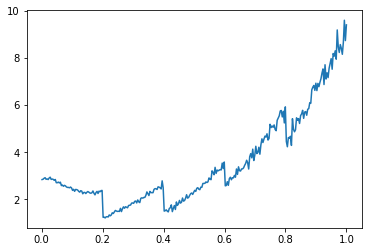

In [147]:
import matplotlib.pyplot as plt 
plt.plot(lrs, losses)
plt.show()

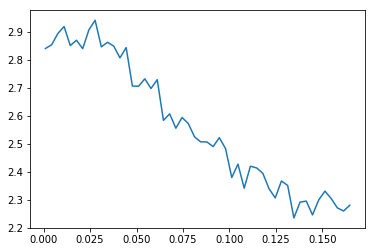

In [149]:
plt.plot(lrs[:50], losses[:50])
plt.show()

In [152]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

V = len(vocab)
D = 50
model = SkipGramModel(V, D).cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.2)

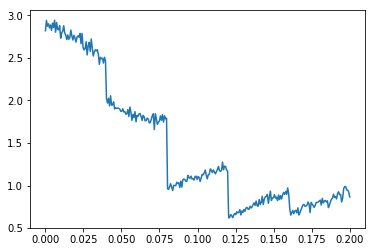

In [153]:
plt.plot(lrs, losses)
plt.show()

In [154]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [155]:
lrs = get_triangular_lr2(lr_low=1e-4, lr_high=0.05, iterations=800)

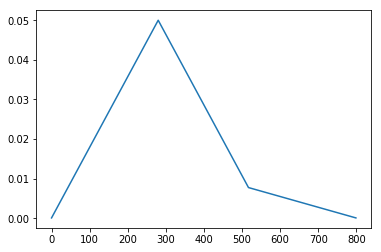

In [156]:
plt.plot(list(range(len(lrs))), lrs)
plt.show()

In [160]:
import time
def train_triangular_policy(model, epochs=4, lr_low=1e-4, lr_high=0.2):
    start_time = time.time()
    
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/(iterations-1)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    
    ind = 0
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for c, t, y in train_dl:
            lr = lrs[ind]
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            c = torch.LongTensor(c).cuda()
            t = torch.LongTensor(t).cuda()
            y = y.float().cuda()
            y_hat = model(c,t)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ind += 1
            total_loss += c.size(0) * loss.item()
            total += c.size(0)
        val_loss = val_metrics(model)
        train_loss = total_loss / total
            
        print('| epoch {:3d} | lr {:02.5f} | train_loss {:5.2f} | val_loss {:5.2f}'.format(
             i, lr, train_loss, val_loss))

In [164]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

V = len(vocab)
D = 50
model = SkipGramModel(V, D).cuda()

In [ ]:
train_triangular_policy(model, epochs=20, lr_low=1e-4, lr_high=0.2)

| epoch   0 | lr 0.02818 | train_loss  2.78 | val_loss  2.52
| epoch   1 | lr 0.05674 | train_loss  2.04 | val_loss  2.02
| epoch   2 | lr 0.08530 | train_loss  1.25 | val_loss  1.99
| epoch   3 | lr 0.11385 | train_loss  0.81 | val_loss  2.10
| epoch   4 | lr 0.14241 | train_loss  0.69 | val_loss  2.30


In [ ]:
p = PATH/"mode1-tri-10.pth"
save_model(model, str(p))

## References
